In [1]:
#pythonではじめるベイズ機会学習３章から

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#データ生成
true_w1 = 1.5
true_w2 = 0.8

#sample data
N = 4
x_data = np.random.uniform(-5, 5, size=N)
y_data = true_w1 * x_data + true_w2 + np.random.normal(0., 1., size=N)

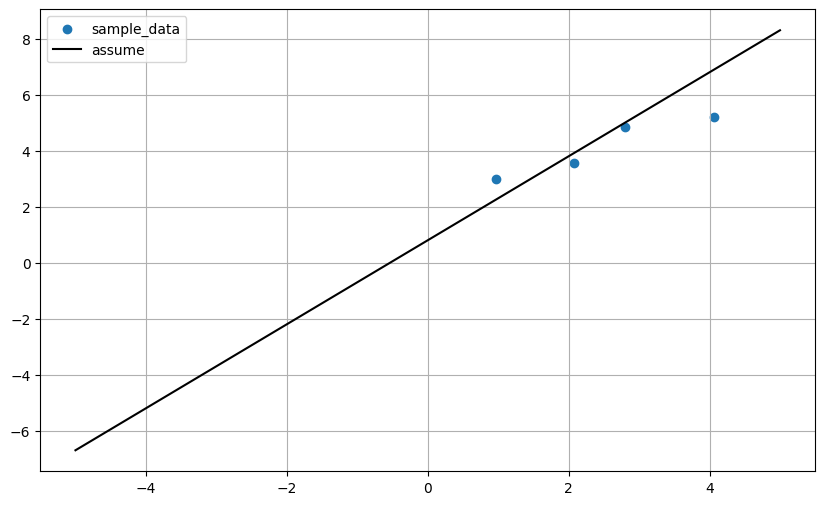

In [4]:
#可視化
plot_x = np.linspace(-5, 5, 100)
plot_y = true_w1 * plot_x + true_w2

plt.figure(figsize=(10,6))
ax = plt.subplot()
ax.scatter(x_data, y_data, marker="o", label="sample_data")
ax.plot(plot_x, plot_y, color="black", label="assume")
plt.grid()
plt.legend()

In [5]:
#bayes model
import pymc as pm
import arviz as az

In [6]:
with pm.Model() as model:
  x = pm.Data('x', x_data)
  w1 = pm.Normal('w1', mu=0.0, sigma=10.0)
  w2 = pm.Normal('w2', mu=0.0, sigma=10.0)
  y = pm.Normal('y', mu=w1*x+w2, sigma=1.0, observed=y_data)

In [7]:
with model:
  trace = pm.sample(draws=3000, tune=1000, chains=3)

Output()

array([[<Axes: title={'center': 'w1'}>, <Axes: title={'center': 'w1'}>],
       [<Axes: title={'center': 'w2'}>, <Axes: title={'center': 'w2'}>]],
      dtype=object)

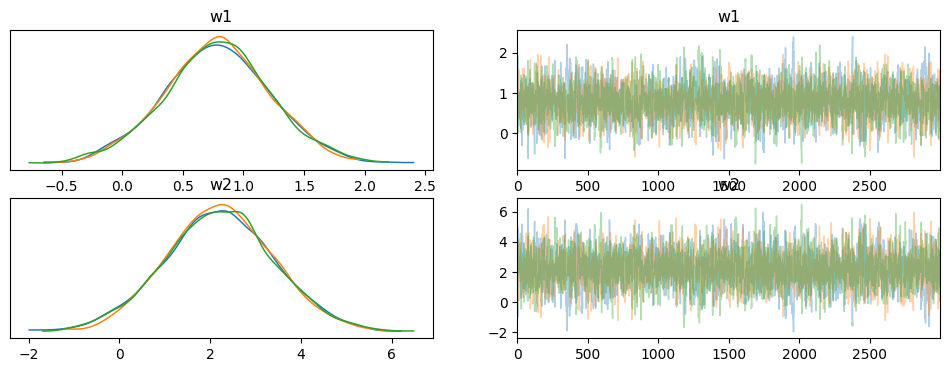

In [8]:
az.plot_trace(trace, compact=False)

array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

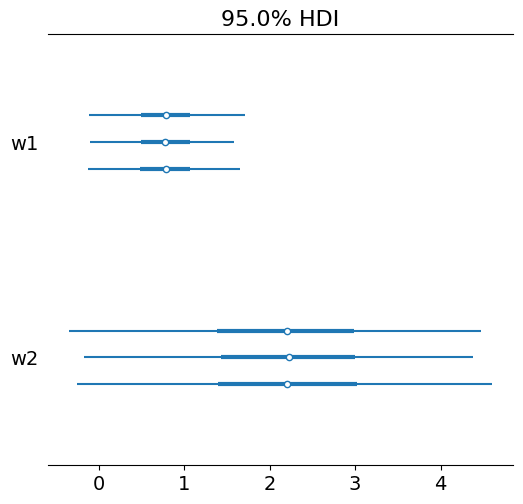

In [9]:
az.plot_forest(trace, hdi_prob=0.95)

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


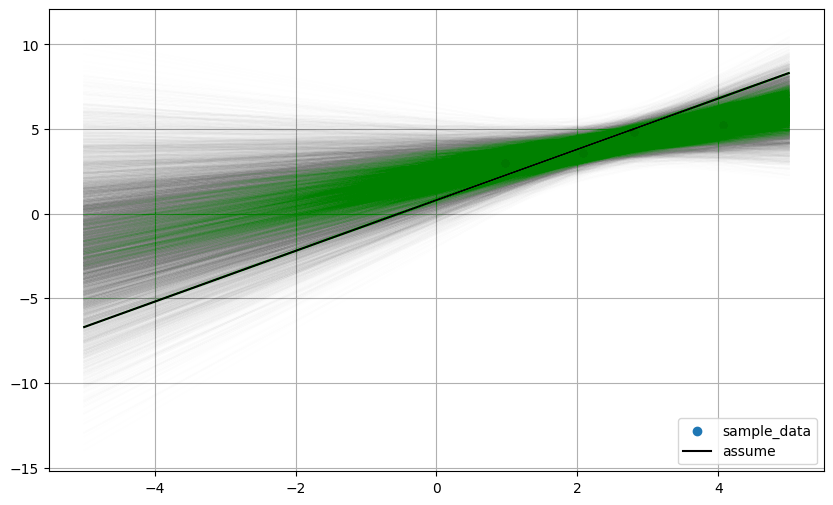

In [10]:
#サンプリングされたｗを使ってシミュレーションする
w1_plot = trace['posterior']['w1'].values.reshape(-1,1)
w2_plot = trace['posterior']['w2'].values.reshape(-1,1)

y_pred = plot_x * w1_plot + w2_plot

plt.figure(figsize=(10,6))
ax = plt.subplot()
ax.scatter(x_data, y_data, marker="o", label="sample_data")
ax.plot(plot_x, plot_y, color="black", label="assume")
plt.grid()
plt.legend()
for i in y_pred:
  plt.plot(plot_x, i, alpha=0.003, color="green")

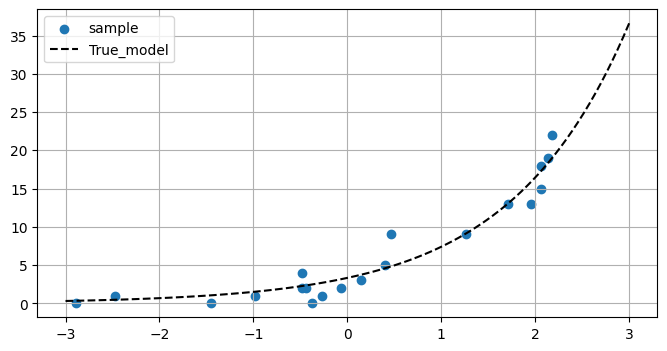

In [11]:
#poisson regression model
from scipy import stats

#データ準備
N = 20
true_w1 = 0.8
true_w2 = 1.2

x_data = np.random.uniform(-3,3,N)
y_data = stats.poisson(mu=np.exp(true_w1*x_data+true_w2)).rvs()

x_plot = np.linspace(-3, 3, 100)
y_plot = stats.poisson(mu=np.exp(x_plot*true_w1+true_w2)).mean()

plt.figure(figsize=(8,4))
plt.scatter(x_data, y_data, label="sample")
plt.plot(x_plot, y_plot, label="True_model", linestyle="--", color="black")
plt.grid()
plt.legend()
plt.show()

In [12]:
with pm.Model() as model:
  x =  pm.Data('x', x_data)
  w1 = pm.Normal('w1', mu=0.0, sigma=1.0)
  w2 = pm.Normal('w2', mu=0.0, sigma=1.0)
  y = pm.Poisson('y', mu=pm.math.exp(w1*x+w2), observed=y_data)

In [13]:
with model:
  trace = pm.sample(draws=3000, tune=1000, chains=3)

Output()

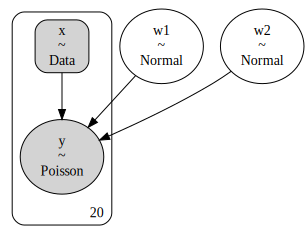

In [14]:
pm.model_to_graphviz(model)

In [15]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w1,0.873,0.095,0.702,1.058,0.002,0.001,2336.0,2646.0,1.0
w2,1.055,0.170,0.733,1.383,0.004,0.003,2269.0,2474.0,1.0


array([[<Axes: title={'center': 'w1'}>, <Axes: title={'center': 'w1'}>],
       [<Axes: title={'center': 'w2'}>, <Axes: title={'center': 'w2'}>]],
      dtype=object)

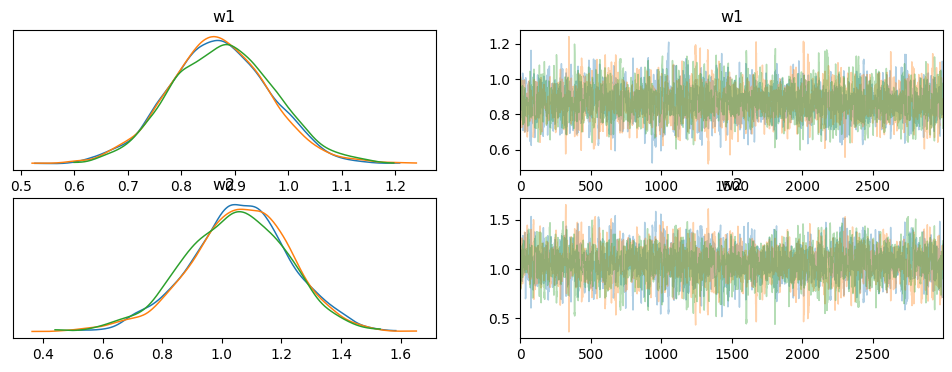

In [16]:
az.plot_trace(trace, compact=False)

array([<Axes: title={'center': 'w1'}>, <Axes: title={'center': 'w2'}>],
      dtype=object)

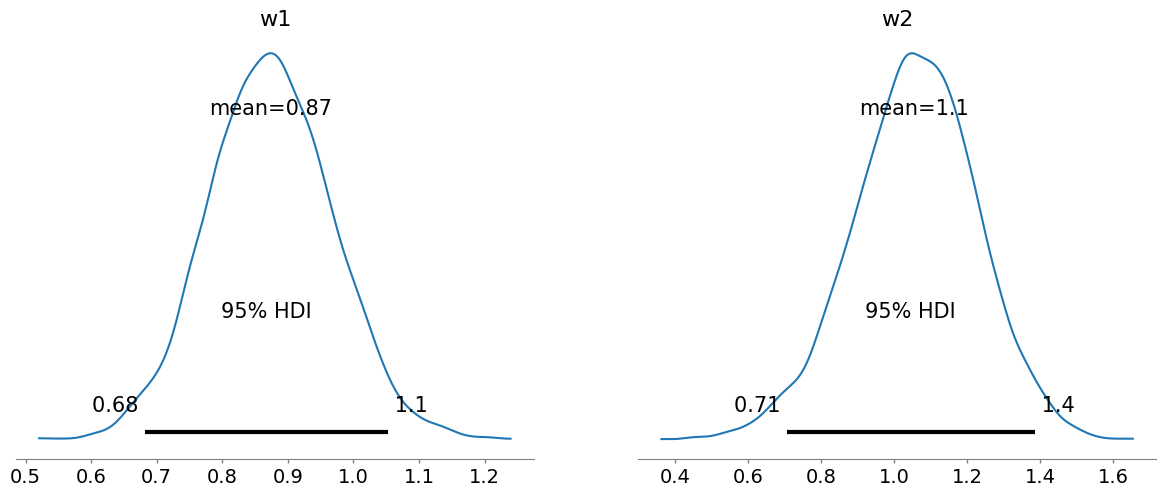

In [17]:
az.plot_posterior(trace, hdi_prob=0.95)

In [18]:
x_plot = np.linspace(-3,3,100)
w1_plot = trace['posterior']['w1'][:1].values.reshape(-1,1)
w2_plot = trace['posterior']['w2'][:1].values.reshape(-1,1)
y_plot = stats.poisson(mu=np.exp(w1_plot*x_plot+w2_plot)).mean()

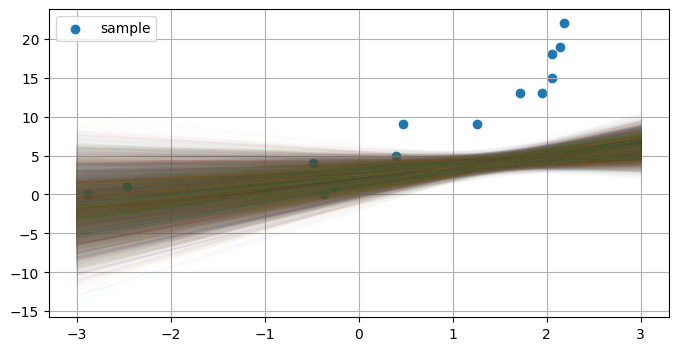

In [19]:
plt.figure(figsize=(8,4))
plt.scatter(x_data, y_data, label="sample")

for i in y_pred:
  plt.plot(x_plot, i, alpha=0.01)

plt.grid()
plt.legend()
plt.show()

In [20]:
y_plot.shape

(3000, 100)

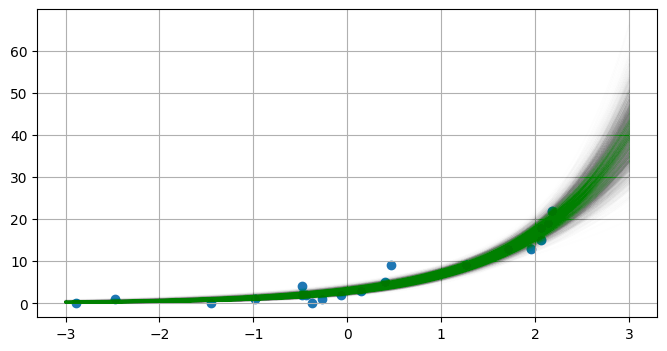

In [21]:
plt.figure(figsize=(8,4))
for i in y_plot:
  plt.plot(x_plot, i, color='green', alpha=0.003, label='assume')

plt.scatter(x_data, y_data, label="sample")

plt.grid()
plt.show()

In [22]:
#logistic regression

In [23]:
import seaborn as sns
iris_dataset = sns.load_dataset('iris')

N = 50
iris_dataset_2pecies = iris_dataset[iris_dataset['species'].isin(['setosa', 'versicolor'])].copy()

In [24]:
iris_dataset_use = iris_dataset_2pecies.sample(N, random_state=1)
x_data = iris_dataset_use[['sepal_length', 'sepal_width']].copy().values
x_data_add_bias = np.concatenate([x_data, np.ones((N,1))], axis=1)
y_data = pd.Categorical(iris_dataset_use['species']).codes

x_data_set = x_data[y_data==0]
x_data_ves = x_data[y_data==1]

In [25]:
y_data

array([1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 1], dtype=int8)

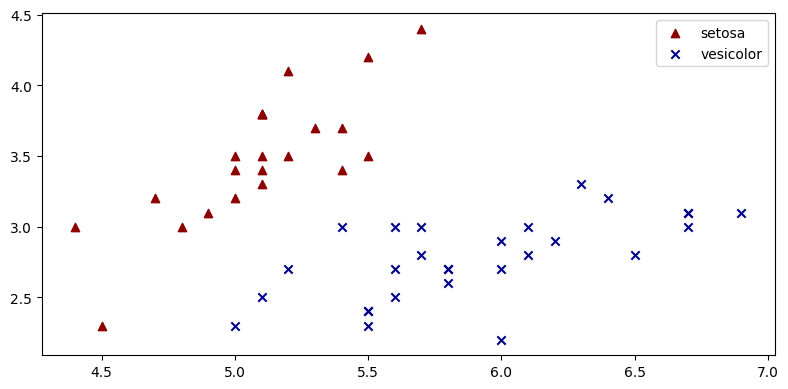

In [26]:
fig, ax = plt.subplots(figsize=(8,4))
ax.scatter(x_data_set[:,0], x_data_set[:,1], color='darkred', marker='^', label='setosa')
ax.scatter(x_data_ves[:,0], x_data_ves[:,1], color='darkblue', marker='x', label='vesicolor')
ax.legend()
plt.tight_layout()
plt.show()

In [27]:
with pm.Model() as model:
  x = pm.Data('x', x_data_add_bias)
  w = pm.Normal('w', mu=0.0, sigma=1.0, shape=3)
  y = pm.Bernoulli('y', logit_p=w.dot(x.T), observed=y_data)

In [28]:
with model:
  trace = pm.sample(draws=3000, tune=1000, chains=3, return_inferencedata=True)

Output()

array([[<Axes: title={'center': 'w'}>, <Axes: title={'center': 'w'}>]],
      dtype=object)

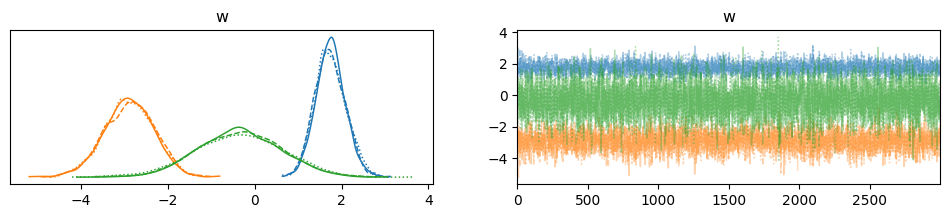

In [29]:
az.plot_trace(trace)

In [30]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w[0],1.745,0.348,1.105,2.396,0.006,0.004,3115.0,3325.0,1.0
w[1],-2.893,0.577,-3.980,-1.840,0.010,0.007,3243.0,3666.0,1.0
w[2],-0.352,0.993,-2.225,1.460,0.015,0.014,4239.0,3671.0,1.0


(2.0, 4.5)

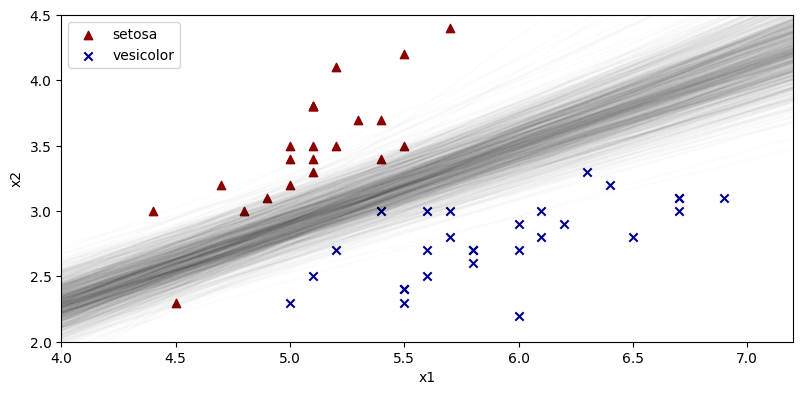

In [31]:
#prediction
w_mcmc_samples = trace.posterior['w'].values.reshape(9000,3)

#　各次元ごとに取り出し
w1_samples = w_mcmc_samples[:,0]
w2_samples = w_mcmc_samples[:,1]
w3_samples = w_mcmc_samples[:,2]

fig, ax = plt.subplots(figsize=(8, 4))
# サンプルデータ
ax.scatter(x=x_data_set[:,0], y=x_data_set[:,1], color='darkred', marker='^',label='setosa')
ax.scatter(x=x_data_ves[:,0], y=x_data_ves[:,1], color='darkblue', marker='x', label='vesicolor')

N_new = 10
x1 = np.linspace(4.0, 7.2, N_new)
for i in range(0, 9000, 10):
  # x1に対してθ=0.5となるx2
  x2 = - w3_samples[i]/w2_samples[i]-w1_samples[i]/w2_samples[i]*x1
  ax.plot(x1, x2, alpha=0.01, color='black')
ax.set_xlabel('x1')
ax.set_ylabel('x2');
ax.legend()
plt.tight_layout()
ax.set_xlim(4.0, 7.2);ax.set_ylim(2.0, 4.5)

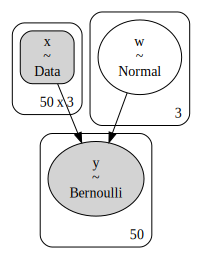

In [32]:
pm.model_to_graphviz(model)

In [33]:
#階層ベイズモデル
np.random.seed(12)
group_num = 9
data_num = 25

a_vector = np.random.normal(1000.0, scale=100.0, size=group_num)
b_vector = np.random.normal(50000.0, scale=500.0, size=group_num)

x_data = np.random.uniform(20, 50, data_num)

group_idx = np.random.randint(0, group_num, data_num)
y_data = a_vector[group_idx] * x_data + b_vector[group_idx] + np.random.normal(0, scale=1500.0, size=data_num)

x_data = np.append(x_data, 33.322)
y_data = np.append(y_data, 75004.54)
group_idx = np.append(group_idx, 8)

# # データ読み込み
#df_data = pd.read_csv('toy_data.csv')
# # 真の係数パラメータデータ
#df_coef = pd.read_csv('true_corf.csv')

df_data = pd.DataFrame([x_data, y_data, group_idx]).T
df_data.columns = ['x', 'y', 'systemID']

df_coef = pd.DataFrame([a_vector, b_vector]).T
df_coef.columns = ['a', 'b']

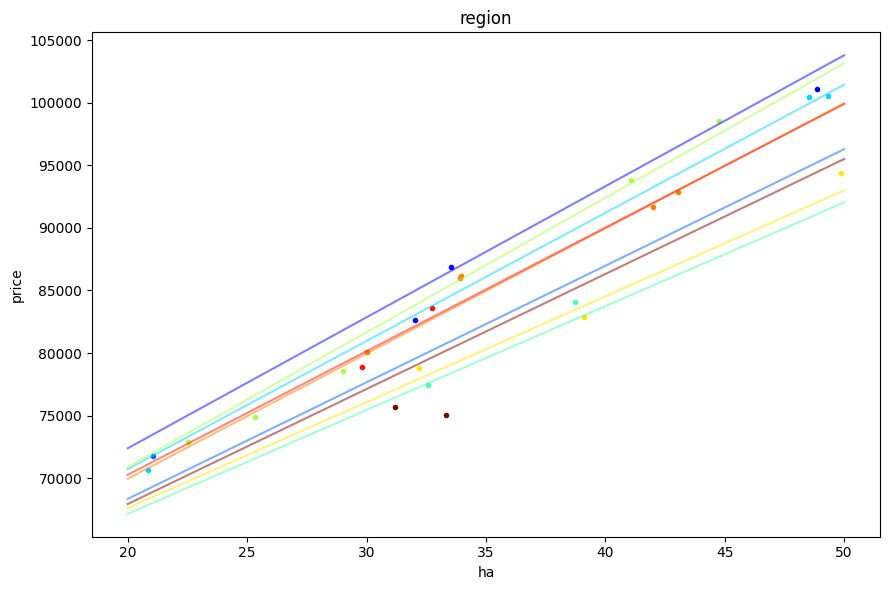

In [34]:
# 説明変数
x_data = df_data['x'].values
# 目的変数
y_data = df_data['y'].values
# 地域グループ
group_idx = df_data['systemID'].values.astype(int)
# 地域毎の傾きとバイアス
a_vector, b_vector = df_coef['a'].values, df_coef['b'].values

# 可視化用
x_linspace = np.linspace(20, 50, 100)

fig, ax = plt.subplots(figsize=(9, 6))
cm10 = plt.get_cmap('jet', 10)
for i in range(9):
  # 真の関数可視化
  ax.plot(x_linspace, a_vector[i]*x_linspace+b_vector[i], color=cm10(i+1), alpha=0.5)
  # 学習データ可視化
  ax.scatter(x_data[group_idx==i], y_data[group_idx==i], marker='.', color=cm10(i+1))

ax.set_xlabel('ha');ax.set_ylabel('price')
ax.set_title('region')
plt.tight_layout()

In [35]:
with pm.Model() as model:
  x = pm.Data('x', x_data)
#地域の傾き'a_offset'はa_mu,a_sigmaにより決定づけられる正規分布
  a_mu = pm.Normal('a_mu', mu=50.0, sigma=10.0)
  a_sigma = pm.HalfCauchy('a_sigma', beta=100.0)
  a_offset = pm.Normal('a_offset', mu=a_mu, sigma=a_sigma, shape=group_num)

#bias
  b_mu = pm.Normal('b_mu', mu=50000.0, sigma=1000.0)
  b_sigma = pm.HalfCauchy('b_sigma', beta=1000.0)
  b_offset = pm.Normal('b_offset', mu=b_mu, sigma=b_sigma, shape=group_num)

  y = pm.Normal('y', mu=a_offset[group_idx]*x+b_offset[group_idx], sigma=1000, observed=y_data)

In [36]:
with model:
  trace = pm.sample(draws=3000, tune=1000, chains=3, return_inferencedata=True)

Output()

ERROR:pymc.stats.convergence:There were 435 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


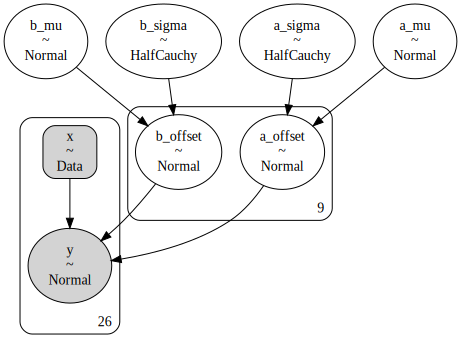

In [37]:
pm.model_to_graphviz(model)

In [38]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_mu,51.614,9.757,32.858,69.846,0.373,0.264,687.0,2075.0,1.01
a_offset[0],1054.273,42.269,972.340,1136.994,0.918,0.649,2023.0,3292.0,1.06
a_offset[1],1037.713,112.242,825.200,1249.296,1.931,1.381,2636.0,3467.0,1.04
a_offset[2],1047.115,30.364,986.618,1103.244,0.710,0.521,1877.0,4952.0,1.02
a_offset[3],884.030,57.556,772.984,996.076,0.801,0.578,4561.0,3616.0,1.05
a_offset[4],1105.224,46.875,1034.643,1198.945,5.941,4.221,57.0,1011.0,1.04
a_offset[5],888.823,38.867,812.874,964.653,0.555,0.392,4248.0,4355.0,1.11
a_offset[6],999.515,54.021,887.903,1088.629,1.526,1.080,1296.0,1492.0,1.06
a_offset[7],1023.243,70.726,874.678,1144.849,1.548,1.095,1038.0,2945.0,1.01
a_offset[8],783.807,73.282,635.215,915.620,1.384,0.979,2509.0,2891.0,1.09


array([[<Axes: title={'center': 'a_mu'}>,
        <Axes: title={'center': 'a_mu'}>],
       [<Axes: title={'center': 'a_sigma'}>,
        <Axes: title={'center': 'a_sigma'}>],
       [<Axes: title={'center': 'a_offset'}>,
        <Axes: title={'center': 'a_offset'}>],
       [<Axes: title={'center': 'b_mu'}>,
        <Axes: title={'center': 'b_mu'}>],
       [<Axes: title={'center': 'b_sigma'}>,
        <Axes: title={'center': 'b_sigma'}>],
       [<Axes: title={'center': 'b_offset'}>,
        <Axes: title={'center': 'b_offset'}>]], dtype=object)

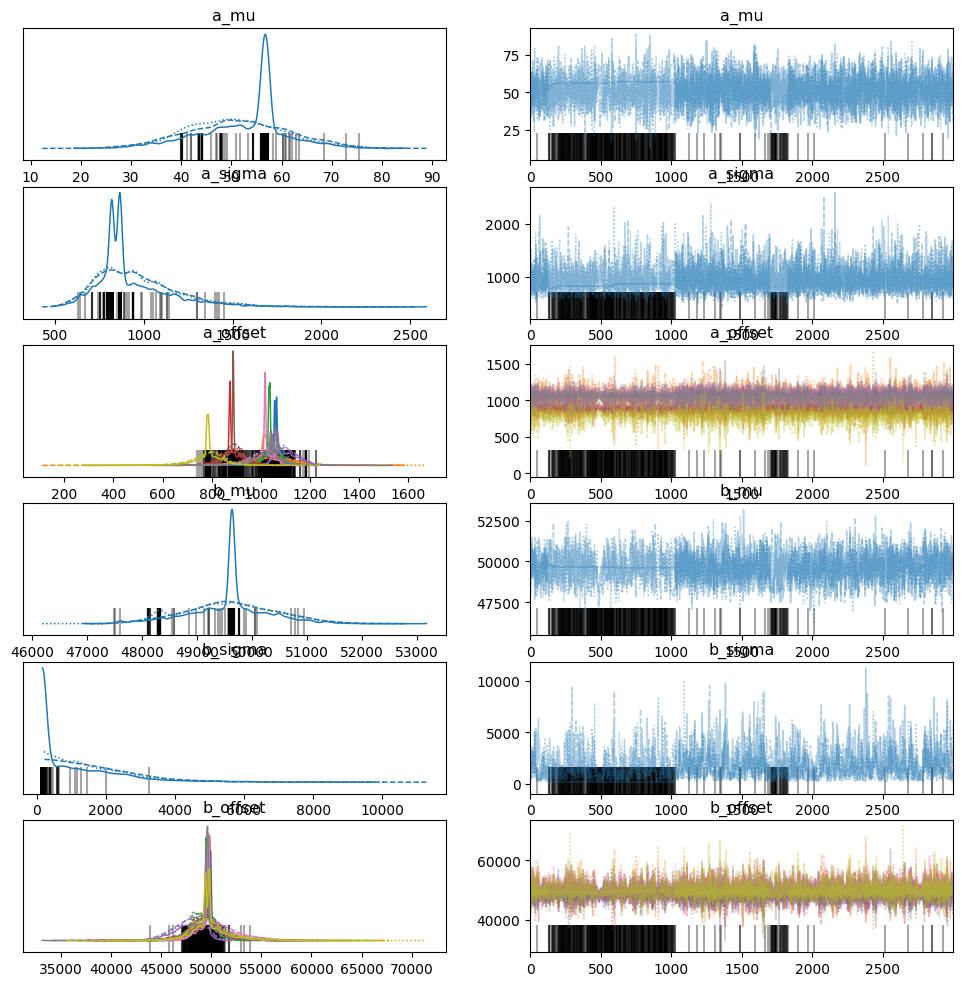

In [39]:
az.plot_trace(trace, var_names=['a_mu', 'a_sigma', 'a_offset', 'b_mu', 'b_sigma', 'b_offset'])

In [49]:
#階層ベイズ事例
df = pd.read_csv('https://raw.githubusercontent.com/kenkenvw/data/main/mikan_pest_insect.csv')

In [81]:
#GLM~poisson_regression
#データの準備、A_agentとB_agent、園地のデータのみ使う
x_data = df[['orchard', 'A-agent', 'B-agent']]
y_data = df['count']
x_data['orchard'] = pd.Categorical(x_data['orchard']).codes
x_data['b0'] = 1
x_data = x_data.astype('float16')
y_data = y_data.astype('float16')

<ipython-input-81-b0e012ce694d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_data['orchard'] = pd.Categorical(x_data['orchard']).codes
<ipython-input-81-b0e012ce694d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_data['b0'] = 1


In [82]:
with pm.Model() as model:
  x = pm.Data('x', x_data)
  w = pm.Normal('w', mu=0.0, sigma=10, shape=4)
  y = pm.Poisson('y', mu=np.exp(w.dot(x.T)), observed=y_data)

In [83]:
with model:
  trace = pm.sample(draws=3000, tune=1000, chain=3)

Output()

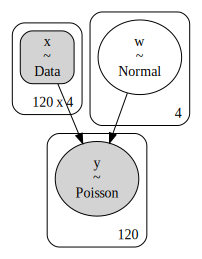

In [84]:
pm.model_to_graphviz(model)

array([<Axes: title={'center': 'w\n0'}>, <Axes: title={'center': 'w\n1'}>,
       <Axes: title={'center': 'w\n2'}>, <Axes: title={'center': 'w\n3'}>],
      dtype=object)

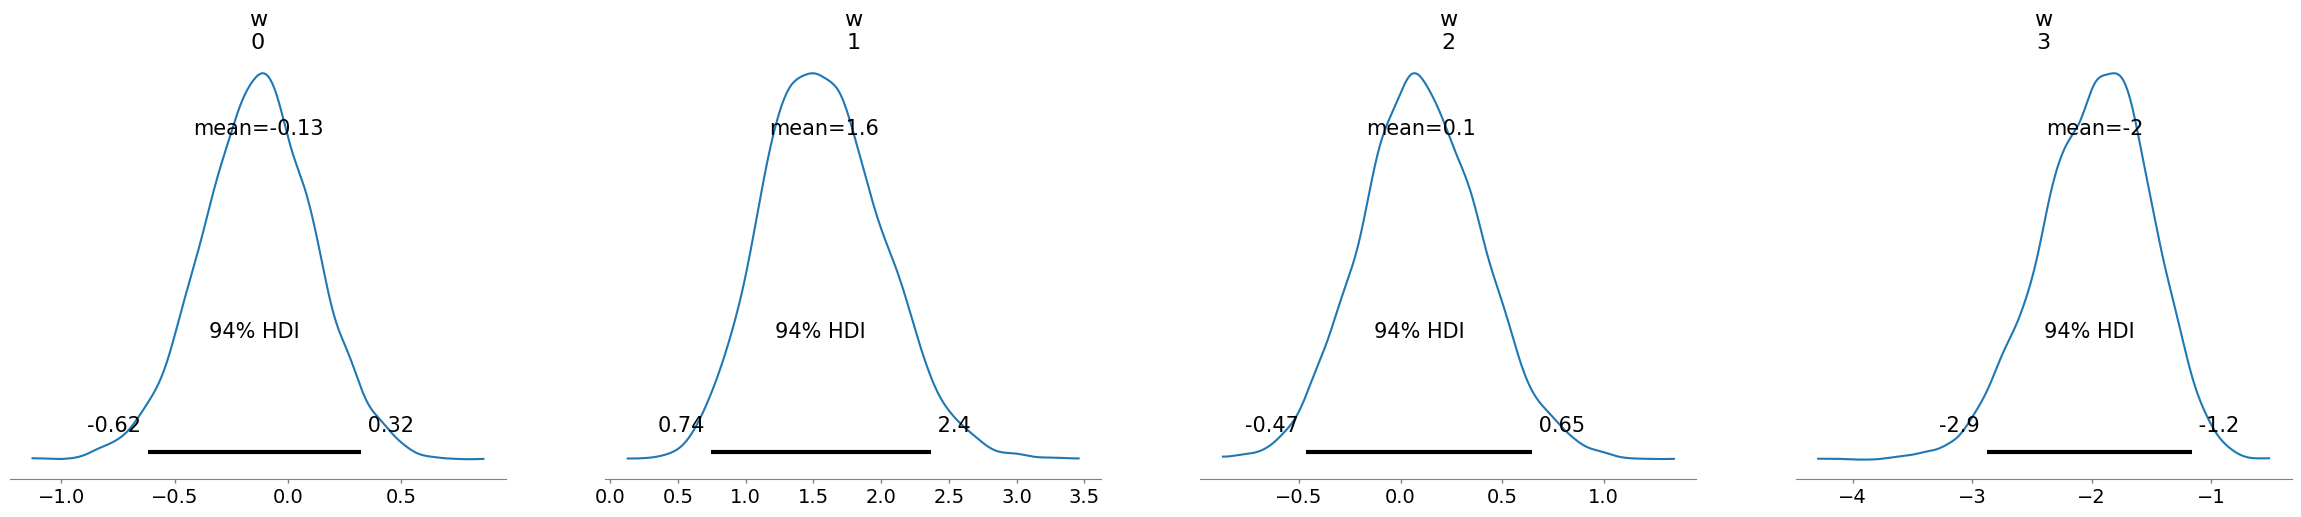

In [85]:
az.plot_posterior(trace)

array([[<Axes: title={'center': 'w\n0'}>,
        <Axes: title={'center': 'w\n0'}>],
       [<Axes: title={'center': 'w\n1'}>,
        <Axes: title={'center': 'w\n1'}>],
       [<Axes: title={'center': 'w\n2'}>,
        <Axes: title={'center': 'w\n2'}>],
       [<Axes: title={'center': 'w\n3'}>,
        <Axes: title={'center': 'w\n3'}>]], dtype=object)

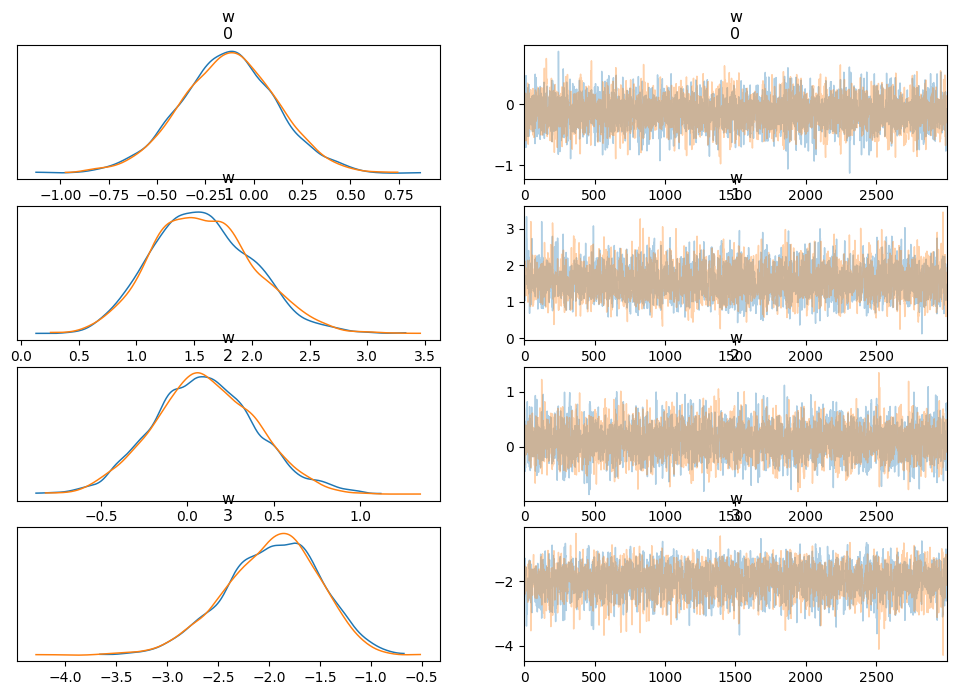

In [87]:
az.plot_trace(trace, compact=False)

In [88]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w[0],-0.132,0.249,-0.618,0.322,0.004,0.003,4998.0,3573.0,1.0
w[1],1.579,0.441,0.742,2.369,0.008,0.006,3199.0,3147.0,1.0
w[2],0.102,0.299,-0.467,0.647,0.005,0.004,3857.0,3189.0,1.0
w[3],-1.974,0.465,-2.877,-1.162,0.008,0.006,3135.0,3421.0,1.0


In [104]:
#ロケーション別に階層化
group_idx = pd.Categorical(df['location']).codes
x_data = x_data.drop(['b0'], axis=1, errors='ignore')

In [105]:
with pm.Model() as model2:
  x1 = pm.Data('x1', x_data['A-agent'])
  x2 = pm.Data('x2', x_data['B-agent'])
  x3 = pm.Data('x3', x_data['orchard'])
  w1_mu = pm.Normal('w1_mu', mu=0.0, sigma=10.0)
  w1_sigma = pm.HalfCauchy('w1_sigma', beta=10.0)
  w2_mu = pm.Normal('w2_mu', mu=0.0, sigma=10.0)
  w2_sigma = pm.HalfCauchy('w2_sigma', beta=10.0)
  w3_mu = pm.Normal('w3_mu', mu=0.0, sigma=10.0)
  w3_sigma = pm.HalfCauchy('w3_sigma', beta=10.0)
  w1 = pm.Normal('w1', mu=w1_mu, sigma=w1_sigma, shape=6)
  w2 = pm.Normal('w2', mu=w2_mu, sigma=w2_sigma, shape=6)
  w3 = pm.Normal('w3', mu=w3_mu, sigma=w3_sigma, shape=6)
  bias = pm.HalfCauchy('bias', beta=10.0)
  y = pm.Poisson('y', mu=np.exp(w1[group_idx]*x1 + w2[group_idx]*x2 + w3[group_idx]*x3 + bias), observed=y_data)

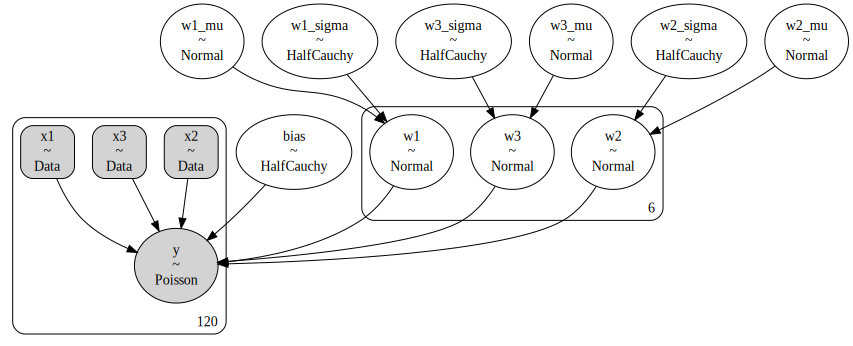

In [106]:
pm.model_to_graphviz(model2)

In [107]:
with model2:
  trace = pm.sample(draws=3000, tune=1000, chain=3)

Output()

ERROR:pymc.stats.convergence:There were 163 divergences after tuning. Increase `target_accept` or reparameterize.


In [108]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bias,0.045,0.043,0.000,0.122,0.001,0.001,3045.0,1807.0,1.00
w1[0],1.689,0.365,1.005,2.353,0.006,0.004,3866.0,4309.0,1.00
w1[1],-2.964,2.023,-6.530,0.110,0.058,0.041,960.0,1476.0,1.00
w1[2],-0.378,0.481,-1.270,0.558,0.017,0.012,764.0,274.0,1.00
w1[3],-0.094,0.404,-0.843,0.669,0.007,0.005,3033.0,4316.0,1.00
w1[4],0.274,0.403,-0.476,0.996,0.008,0.008,2229.0,2123.0,1.00
w1[5],-0.479,0.544,-1.546,0.480,0.009,0.007,3628.0,4292.0,1.00
w1_mu,-0.333,1.024,-2.413,1.422,0.023,0.020,2048.0,1682.0,1.00
w1_sigma,2.113,1.285,0.452,4.319,0.030,0.022,1460.0,2575.0,1.00
w2[0],-1.937,0.462,-2.807,-1.070,0.007,0.005,3888.0,3454.0,1.00


array([[<Axes: title={'center': 'bias'}>,
        <Axes: title={'center': 'bias'}>],
       [<Axes: title={'center': 'w1'}>, <Axes: title={'center': 'w1'}>],
       [<Axes: title={'center': 'w1_mu'}>,
        <Axes: title={'center': 'w1_mu'}>],
       [<Axes: title={'center': 'w1_sigma'}>,
        <Axes: title={'center': 'w1_sigma'}>],
       [<Axes: title={'center': 'w2'}>, <Axes: title={'center': 'w2'}>],
       [<Axes: title={'center': 'w2_mu'}>,
        <Axes: title={'center': 'w2_mu'}>],
       [<Axes: title={'center': 'w2_sigma'}>,
        <Axes: title={'center': 'w2_sigma'}>],
       [<Axes: title={'center': 'w3'}>, <Axes: title={'center': 'w3'}>],
       [<Axes: title={'center': 'w3_mu'}>,
        <Axes: title={'center': 'w3_mu'}>],
       [<Axes: title={'center': 'w3_sigma'}>,
        <Axes: title={'center': 'w3_sigma'}>]], dtype=object)

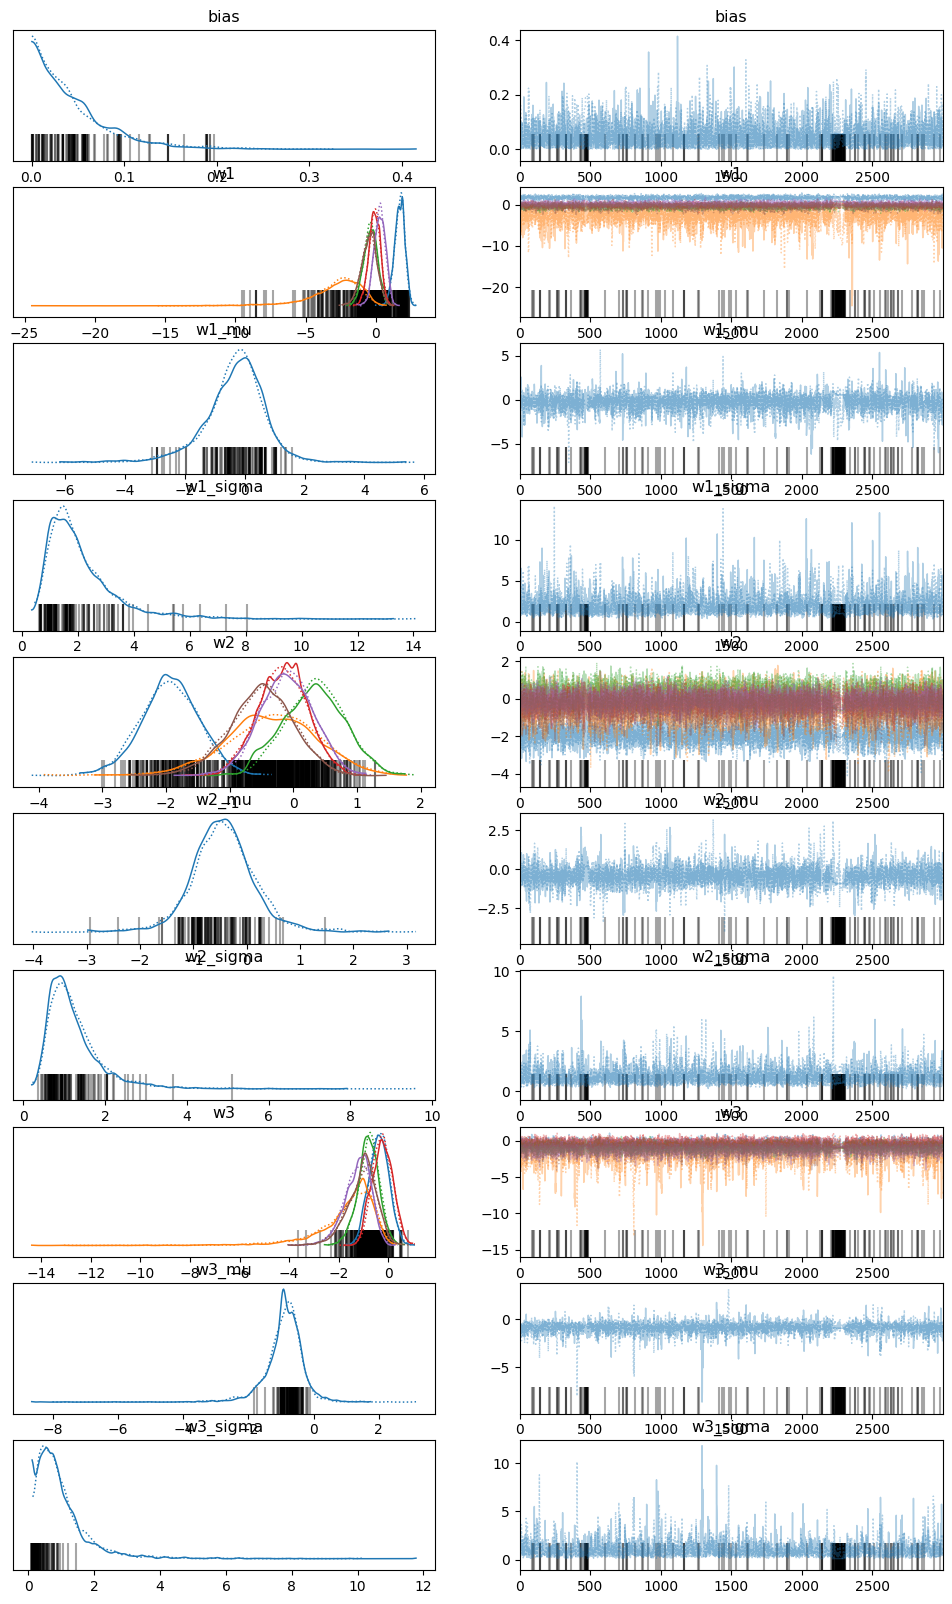

In [109]:
az.plot_trace(trace)